In [1]:
# inpath = 'gemma2-9b/output_temperature_0.0/'

# time
# inpath = 'gemma2-time/output_temperature_time_gemma2b-mps' #.89
inpath = 'gemma2-time/output_temperature_time_gemma2b_colab_partial' #.89
# inpath = 'gemma2-time/output_temperature_time_gemma9b' # .87
# inpath = 'gemma2-time/output_temperature_time_gemma2b-mps_finegrained'

In [2]:
# for folder in $(ls -d tablellama/*/); do papermill temperature-preprocess.ipynb -p inpath $folder tmp.json; don

In [3]:
prefix, folder = inpath.split('/')[:2]

In [4]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import pandas as pd
import seaborn as sns
import pickle
import math
from IPython.display import clear_output
import numpy as np
import re
import os

sns.set_context("notebook", font_scale=1.25)
 
file_path = "turl_test_2k_prompts_50_unique.jsonl"
device = torch.device("mps")

In [5]:
# https://github.com/ipython-contrib/jupyter_contrib_nbextensions/pull/1663

In [6]:
from io import BytesIO

def fix(map_loc):
    # Closure rather than a lambda to preserve map_loc 
    return lambda b: torch.load(BytesIO(b), map_location=map_loc)

class MappedUnpickler(pickle.Unpickler):
    # https://github.com/pytorch/pytorch/issues/16797#issuecomment-633423219

    def __init__(self, *args, map_location='cpu', **kwargs):
        self._map_location = map_location
        super().__init__(*args, **kwargs)

    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return fix(self._map_location)
        else: 
            return super().find_class(module, name)

def mapped_loads(s, map_location='cpu'):
    bs = BytesIO(s)
    unpickler = MappedUnpickler(bs, map_location=map_location)
    return unpickler.load()

In [7]:
# prompt formatting

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input_seg}\n\n### Question:\n{question}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

def generate_prompt(instruction, question, input_seg=None):
    question += " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    if input_seg:
        return PROMPT_DICT["prompt_input"].format(instruction=instruction, input_seg=input_seg, question=question)
    else:
        return PROMPT_DICT["prompt_no_input"].format(instruction=instruction)

In [8]:
# load questions (to be removed)

with open(file_path, "r", encoding="utf-8") as f:
    prompts = [json.loads(line) for line in f]

In [9]:
os.path.join(prefix, folder)

'gemma2-time/output_temperature_time_gemma2b_colab_partial'

In [10]:
import os
import pickle
from copy import copy, deepcopy

pre_keys = ['pre_output_proba_topn',
 'pre_output_proba_topk',
 'pre_output_true_entropies',
 'pre_output_layers_kl']

run = 0
outlist = []

times = []

for pid, single_file in enumerate(os.listdir(os.path.join(prefix, folder))):
    if single_file.startswith('_') or single_file.startswith('.'): continue
    with open(os.path.join(prefix, folder, single_file), 'rb') as handle:        
        item = mapped_loads(handle.read())
        
        times.append((run, item['pid'], 
                      item.get('elapsed_forward', None), 
                      item.get('elapsed', None),
                      item.get('elapsed_copytime', None),
                      item.get('elapsed_generatetime', None)))
        
        for i, _ in enumerate(item["post_output_sequences"]):
                
            item_ = copy(item)
            item_["post_output_sequences"] = item["post_output_sequences"][i]
                
            item_["transition_scores_s"] = item["transition_scores_s"][i]
            item_["transition_scores_l"] = item["transition_scores_l"][i]

            item_["run"] = run + i
                
            outlist.append(item_)
    

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_28594/3807410893.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return lambda b: torch.load(BytesIO(b), map_l

In [11]:
item.keys()

dict_keys(['table', 'cell', 'instruction', 'input', 'question', 'output', 'prompt', 'tokenized_inputs', 'post_output_sequences', 'transition_scores_s', 'transition_scores_l', 'elapsed_forward', 'elapsed', 'args', 'pid'])

### times

In [20]:
# generated includes the forward

times = pd.DataFrame(times, columns=['run', 'pid', 'forward', 'generated', 'copy', 'generate_only'])

In [21]:
times['gen_ratio_overall'] = (times['generated'] - times['forward']) / times['generated']
times['gen_ratio_overall'].mean(), times['gen_ratio_overall'].median()

(0.8743704839638318, 0.8833175447458237)

In [22]:
times['gen_ratio_only'] = times['generate_only'] / times['generated']
times['gen_ratio_only'].mean(), times['gen_ratio_only'].median()

/Users/bono/miniforge3/envs/doubt/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


(nan, nan)

In [23]:
times['gen_ratio_only']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
109    NaN
110    NaN
111    NaN
112    NaN
113    NaN
Name: gen_ratio_only, Length: 114, dtype: object

In [16]:
if ~times['gen_ratio_only'].isnull().any():
    times['gen_ratio_only'].mean().round(2)*100

In [17]:
if ~times['gen_ratio_only'].isnull().any():
    times['gen_ratio_copy'] = times['copy'] / times['generated']
    times['gen_ratio_copy'].mean(), times['gen_ratio_copy'].median()

In [18]:
times

,run,pid,forward,generated,copy,generate_only,gen_ratio_overall,gen_ratio_only
0,0,567,2.933091,20.286258,None,None,0.855415,NaN
1,0,17,1.869640,9.910088,None,None,0.811340,NaN
2,0,224,2.996209,26.907116,None,None,0.888646,NaN
3,0,96,2.578435,19.765980,None,None,0.869552,NaN
4,0,457,2.226766,19.084897,None,None,0.883323,NaN
...,...,...,...,...,...,...,...,...
109,0,182,1.803506,15.786305,None,None,0.885755,NaN
110,0,924,3.155528,25.549336,None,None,0.876493,NaN
111,0,323,3.145976,27.152772,None,None,0.884138,NaN
112,0,866,1.866042,19.706815,None,None,0.905310,NaN


In [19]:
times.gen_ratio_overall.median()

0.8833175447458237

In [25]:
# prefix, model_name = './tablellama-complete/', "osunlp/TableLlama"
# prefix, model_name = './gemma-9b-complete/', "google/gemma-2-9b-it"

model_name = item['args']['model_name'] # get model from last processed item
print(model_name)

if model_name.startswith("osunlp"):
    config = transformers.AutoConfig.from_pretrained(model_name)

    orig_ctx_len = getattr(config, "max_position_embeddings", None)
    context_size = 8192
    if orig_ctx_len and context_size > orig_ctx_len:
            scaling_factor = float(math.ceil(context_size / orig_ctx_len))
            config.rope_scaling = {"type": "linear", "factor": scaling_factor}

    tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                              model_max_length=(context_size if context_size > orig_ctx_len else orig_ctx_len),
                                              padding_side="left", 
                                              use_fast=False)

else:
    config = transformers.AutoConfig.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

google/gemma-2-2b-it


### check output against ground truth

In [26]:
%%time

# show results

c=0
t=0
h=0
noans = 0

truth = []
outseq = []

pdbg = None

for idx, p in enumerate(outlist):
    
    if idx%100==0: 
        clear_output(wait=True)
        print(idx, end='\r')
    c+=1
    pdbg = p
    
    # in
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
        
    # computed
    # post_output_scores = p['post_output_scores']
    post_output_sequences = p['post_output_sequences']
    
    # bases
    baseid = len(inputs["input_ids"][0]) + 1
    endid = len(post_output_sequences[0])
    # lookout
    generated_ids = post_output_sequences
    generated_text = tokenizer.decode(generated_ids[0][baseid:endid], skip_special_tokens=True)
    # print
    # print(generated_text)
    # print(p['output'])
    # print('\n')
    #test
    
    # replacement due to tablellama "hallucinations"
    a = generated_text.replace('[DESCRIPTION]', '[DESC]').lower().strip()
    a = " ".join(a.split(" "))
    if len(a) < 1: 
        print("SOMETHING WENT HORRIBLY WRONG, GIVING UP")
        noans += 1
        a = "NO ANSWER"

    b = p['output'].lower().strip()
    b = " ".join(b.split(" "))
    # correct
    correct = False
    hallucinated = False
    if ((a in b) or (b in a) or (b.startswith(a)) or (a.startswith(b))) and (('desc' in a) and ('type' in a)): 
        correct = True
        t+=1
    # hallucinated
    elif a not in prompt.lower().strip(): 
        h+=1
        hallucinated = True
    # incorrect
    else:
        pass
        #print(generated_text)
        #print(p['output'])
        #print('\n')
        # print(prompt)
        # print('\n')
        
    # loose correctness
    _, three_ = b.split('[type]')
    one_, two_ = _.split('[desc]')
    one_ = one_.replace('<', '').replace('>', '').replace(']', '').replace('[', '').strip()
    two_ = two_.replace('<', '').replace('>', '').replace(']', '').replace('[', '').strip()
    three_ = three_.replace('<', '').replace('>', '').replace(']', '').replace('[', '').strip()
    
    loosely_correct = False
    matched_string = None
    try:                  
        regex = re.compile(r'^.{0,2}(' + re.escape(one_) + r'.{0,8}' + re.escape(two_) + r'.{0,8}' + re.escape(three_) + r')')
        match = regex.search(a)
        if match: 
            loosely_correct = True
            matched_string = match.group(1)
    except Exception as e:
        pass# if it fails, default

    truth.append((p['run'], p['pid'], correct, hallucinated, loosely_correct))
    outseq.append((p['run'], p['pid'], a, post_output_sequences, b, matched_string))


CPU times: user 2.54 s, sys: 393 ms, total: 2.93 s
Wall time: 3.41 s


In [27]:
len(inputs.input_ids[0]), len(post_output_sequences[0])

(1941, 1958)

In [28]:
# true, hallucinated, counted
# (3702, 26, 5120) tablellama old
# (11190, 880, 14770) gemma 9b
t, h, c

(249, 375, 1140)

In [29]:
# correct answers rate, hallucinated answers rate
t/c, h/c

(0.21842105263157896, 0.32894736842105265)

In [30]:
truth = pd.DataFrame(truth, columns=['run', 'pid', 'correct', 'hallucinated', 'loosely_correct'])

In [31]:
corec = truth.groupby('pid').correct.mean()

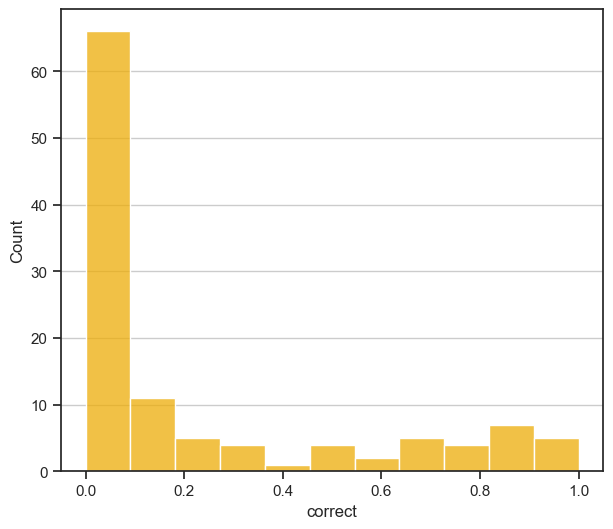

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 6))

sns.histplot(corec, bins=corec.nunique(), color=Prism_10.mpl_colors[5])

ax.yaxis.grid(True)

plt.show()

In [33]:
# probability mass for "convinced" prediction
(np.isclose(corec, 0.) | np.isclose(corec, 1.)).sum() / corec.shape[0]

0.6228070175438597

In [34]:
# how many "changed at least once"
((corec>0.) & (corec<1.)).sum() / corec.shape[0]

0.37719298245614036

In [35]:
# again but without hallucinated

truth_ = truth[(~truth.hallucinated)].copy()
truth_['true_err'] = truth_.correct

corec_ = truth_.groupby('pid').true_err.mean()

((corec_>0.) & (corec_<1.)).sum() / corec_.shape[0]

0.25892857142857145

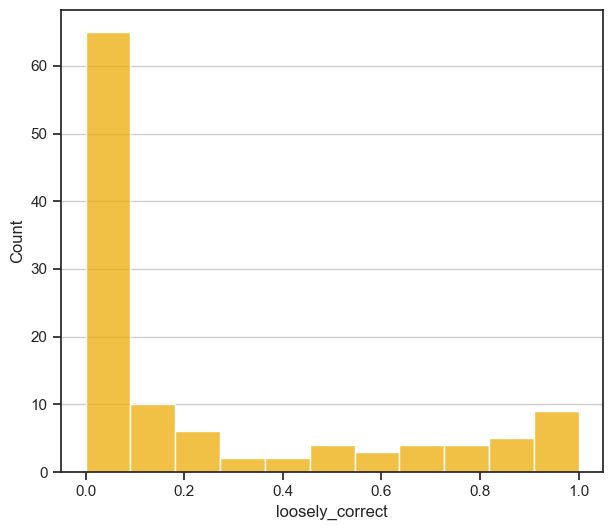

In [36]:
# loosely correct

import seaborn as sns
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

sns.set_theme(style="ticks")

corek = truth.groupby('pid').loosely_correct.mean()

f, ax = plt.subplots(figsize=(7, 6))

sns.histplot(corek, bins=corek.nunique(), color=Prism_10.mpl_colors[5])

ax.yaxis.grid(True)

plt.show()

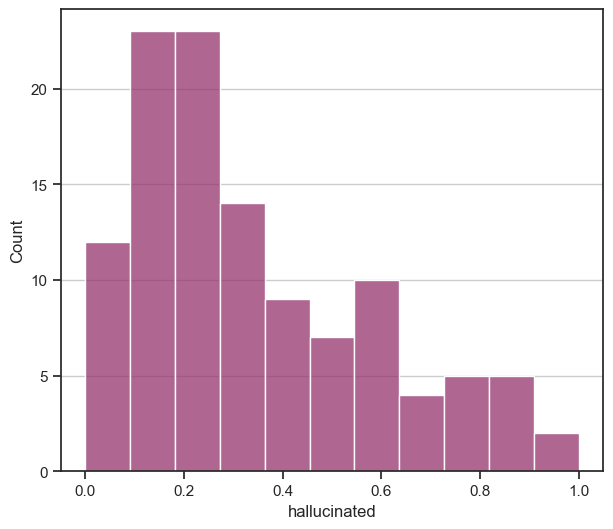

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 6))

sns.histplot(truth.groupby('pid').hallucinated.mean(), bins=corec.nunique(), color=Prism_10.mpl_colors[8])

ax.yaxis.grid(True)

plt.show()

In [38]:
# how many hallucinated
(truth.groupby('pid').hallucinated.mean()>0.).sum() / truth.pid.nunique()

0.8947368421052632

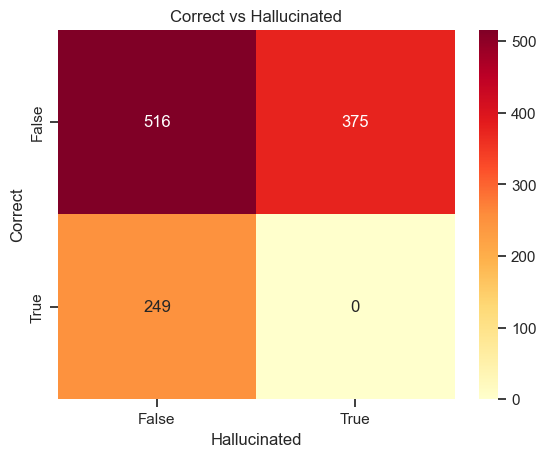

In [39]:
contingency = pd.crosstab(truth.correct, truth.hallucinated)

sns.heatmap(contingency, annot=True, fmt="d", cmap="YlOrRd")

plt.title("Correct vs Hallucinated")
plt.xlabel("Hallucinated")
plt.ylabel("Correct")
plt.show()

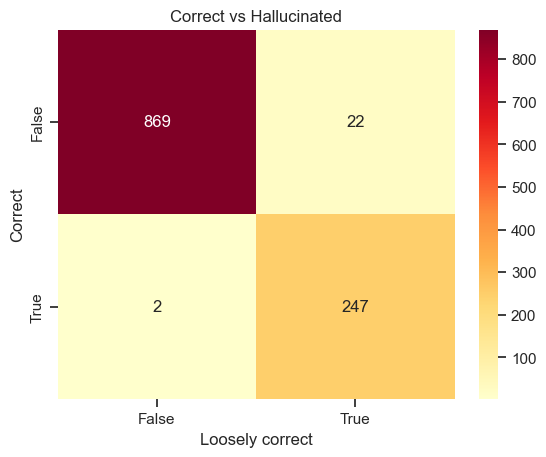

In [40]:
contingency = pd.crosstab(truth.correct, truth.loosely_correct)

sns.heatmap(contingency, annot=True, fmt="d", cmap="YlOrRd")

plt.title("Correct vs Hallucinated")
plt.xlabel("Loosely correct")
plt.ylabel("Correct")
plt.show()

In [41]:
# answers
answers = pd.DataFrame(outseq, columns=['run', 'pid', 'answer', 'answer_seq', 'right_answer', 'regex_match'])
answers.answer = answers.answer.str[:-1]

In [42]:
# min and max number of unique answers
answers.groupby('pid').answer.nunique().min(), answers.groupby('pid').answer.nunique().max()

(1, 10)

In [43]:
answers

,run,pid,answer,answer_seq,right_answer,regex_match
0,0,567,<ruud geels [desc] dutch footballer [type] human,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...",<ruud geels [desc] dutch footballer [type] human>,ruud geels [desc] dutch footballer [type] human
1,1,567,<ruud geels [desc] dutch footballer [type] human,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...",<ruud geels [desc] dutch footballer [type] human>,ruud geels [desc] dutch footballer [type] human
2,2,567,<ruud geels [desc] dutch footballer [type] human,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...",<ruud geels [desc] dutch footballer [type] human>,ruud geels [desc] dutch footballer [type] human
3,3,567,<ruud geels [desc] dutch footballer [type] hum...,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...",<ruud geels [desc] dutch footballer [type] human>,ruud geels [desc] dutch footballer [type] human
4,4,567,<geels [desc] family name [type] family name,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...",<ruud geels [desc] dutch footballer [type] human>,None
...,...,...,...,...,...,...
1135,5,190,1996–97 uefa champions league,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...",<maccabi tel aviv f.c. [desc] association foot...,None
1136,6,190,<1996–97 uefa champions league. qualifying roun,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...",<maccabi tel aviv f.c. [desc] association foot...,None
1137,7,190,1996–97 uefa champions leagu,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...",<maccabi tel aviv f.c. [desc] association foot...,None
1138,8,190,1996–97 uefa champions league,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...",<maccabi tel aviv f.c. [desc] association foot...,None


In [44]:
# wrong answers

import numpy as np
def fun (a,b):
    return a.startswith(b) or b.startswith(a)

foon = np.vectorize(fun)
aoh = pd.Series(foon(answers.answer, answers.right_answer), index=answers.index)

answers[~aoh]

,run,pid,answer,answer_seq,right_answer,regex_match
4,4,567,<geels [desc] family name [type] family name,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...",<ruud geels [desc] dutch footballer [type] human>,None
10,0,17,huánuco distric,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...",<huanuco [desc] region of peru [type] region o...,None
11,1,17,huánuco distric,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...",<huanuco [desc] region of peru [type] region o...,None
12,2,17,huánuco distric,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...",<huanuco [desc] region of peru [type] region o...,None
13,3,17,león de huánuc,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...",<huanuco [desc] region of peru [type] region o...,None
...,...,...,...,...,...,...
1135,5,190,1996–97 uefa champions league,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...",<maccabi tel aviv f.c. [desc] association foot...,None
1136,6,190,<1996–97 uefa champions league. qualifying roun,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...",<maccabi tel aviv f.c. [desc] association foot...,None
1137,7,190,1996–97 uefa champions leagu,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...",<maccabi tel aviv f.c. [desc] association foot...,None
1138,8,190,1996–97 uefa champions league,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...",<maccabi tel aviv f.c. [desc] association foot...,None


In [45]:
pd.set_option('max_colwidth', 200)

In [46]:
# correct but not loosely correct?
gg = pd.merge(truth, answers, on=['run', 'pid'], how='inner')
gg[(~gg.loosely_correct) & (gg.correct)]

,run,pid,correct,hallucinated,loosely_correct,answer,answer_seq,right_answer,regex_match
967,7,265,True,False,False,walker [desc] english singer and actor [type] opera singer,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, 6911, 235269, 44600, 675, 671, 3772, 674, 6572, 4024, 4807, 235265, 15615, 476, 3590, 674, 47258, 56382, 573, 3853, 235265, 109, 6176, 36142, 235292, ...",<richard walker [desc] english singer and actor [type] opera singer>,None
969,9,265,True,False,False,walker [desc] english singer and actor [type] opera singe,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, 6911, 235269, 44600, 675, 671, 3772, 674, 6572, 4024, 4807, 235265, 15615, 476, 3590, 674, 47258, 56382, 573, 3853, 235265, 109, 6176, 36142, 235292, ...",<richard walker [desc] english singer and actor [type] opera singer>,None


In [47]:
# only loosely correct
gg = pd.merge(truth, answers, on=['run', 'pid'], how='inner')
gg[(gg.loosely_correct) & (~gg.correct)].drop_duplicates(subset='pid')

,run,pid,correct,hallucinated,loosely_correct,answer,answer_seq,right_answer,regex_match
60,0,568,False,True,True,chairman of the standing committee of the national people's congress [desc] high constitutional office of china [type] position,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, 6911, 235269, 44600, 675, 671, 3772, 674, 6572, 4024, 4807, 235265, 15615, 476, 3590, 674, 47258, 56382, 573, 3853, 235265, 109, 6176, 36142, 235292, ...",<chairman of the standing committee of the national people's congress [desc] high constitutional office of china [type] position>,chairman of the standing committee of the national people's congress [desc] high constitutional office of china [type] position
116,6,204,False,True,True,pobla de mafumet cf [desc] spanish association football club [type] association football club,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, 6911, 235269, 44600, 675, 671, 3772, 674, 6572, 4024, 4807, 235265, 15615, 476, 3590, 674, 47258, 56382, 573, 3853, 235265, 109, 6176, 36142, 235292, ...",<pobla de mafumet cf [desc] spanish association football club [type] association football club>,pobla de mafumet cf [desc] spanish association football club [type] association football club
140,0,127,False,True,True,"waterloo diamonds <desc> former baseball team based in waterloo, iowa [type] baseball team","[[2, 33501, 603, 671, 14239, 674, 19306, 476, 6911, 235269, 44600, 675, 671, 3772, 674, 6572, 4024, 4807, 235265, 15615, 476, 3590, 674, 47258, 56382, 573, 3853, 235265, 109, 6176, 36142, 235292, ...","<waterloo diamonds [desc] former baseball team based in waterloo, iowa [type] baseball team>","waterloo diamonds <desc> former baseball team based in waterloo, iowa [type] baseball team"
152,2,263,False,True,True,john mcenroe [desc] american tennis player [type] tennis player,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, 6911, 235269, 44600, 675, 671, 3772, 674, 6572, 4024, 4807, 235265, 15615, 476, 3590, 674, 47258, 56382, 573, 3853, 235265, 109, 6176, 36142, 235292, ...",<john mcenroe [desc] american tennis player [type] tennis player>,john mcenroe [desc] american tennis player [type] tennis player
344,4,858,False,True,True,luke bailey [desc] australian rugby league footballer [type] rugby league player,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, 6911, 235269, 44600, 675, 671, 3772, 674, 6572, 4024, 4807, 235265, 15615, 476, 3590, 674, 47258, 56382, 573, 3853, 235265, 109, 6176, 36142, 235292, ...",<luke bailey [desc] australian rugby league footballer [type] rugby league player>,luke bailey [desc] australian rugby league footballer [type] rugby league player
373,3,183,False,True,True,"robert wise [desc] american film director, film producer and film editor [type] trade unionist \n\n\n### explanation:\n the input for this task provides the entities, their description and their t...","[[2, 33501, 603, 671, 14239, 674, 19306, 476, 6911, 235269, 44600, 675, 671, 3772, 674, 6572, 4024, 4807, 235265, 15615, 476, 3590, 674, 47258, 56382, 573, 3853, 235265, 109, 6176, 36142, 235292, ...","<robert wise [desc] american film director, film producer and film editor [type] trade unionist>","robert wise [desc] american film director, film producer and film editor [type] trade unionist"
413,3,234,False,True,True,<riff raffy daffy [desc]1948 cartoon directed by arthur davis [type] animated short film,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, 6911, 235269, 44600, 675, 671, 3772, 674, 6572, 4024, 4807, 235265, 15615, 476, 3590, 674, 47258, 56382, 573, 3853, 235265, 109, 6176, 36142, 235292, ...",<riff raffy daffy [desc] 1948 cartoon directed by arthur davis [type] animated short film>,riff raffy daffy [desc]1948 cartoon directed by arthur davis [type] animated short film
444,4,774,False,True,True,[countess amalie elisabeth of hanau-münzenberg [desc] regent of hesse-kassel (1602-1651) [type] ruler,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, 6911, 235269, 44600, 675, 671, 3772, 674, 6572, 4024, 4807, 235265, 15615, 476, 3590,

### sequence components alignment
### (build "segments" for each sequence)

In [48]:
def is_sublist(c, m, label):
    if not c: return False
    if not m or len(c) > len(m): return False

    for i in range(len(m) - len(c) + 1):
        if m[i:i+len(c)] == c:
            return (i, i + len(c), label)
    return False

In [49]:
# %%time

checks = []
alls = set()

for idx, p in enumerate(outlist):
    if idx%100==0: 
        clear_output(wait=True)
        print(idx, end='\r')
    
    run = p['run']
    pid = p['pid']
    
    alls.add(p['table'])
    
    # this is the generated sequence
    output_seq = p['post_output_sequences'][0]
    
    # overall prompt sequence
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    prompt_seq = tokenizer(prompt, return_tensors="pt")
    prompt_seq = prompt_seq['input_ids'][0].numpy().tolist()

    # subsequences
    instruction_seq = tokenizer(p["instruction"], return_tensors="pt")
    instruction_seq = instruction_seq['input_ids'][0].numpy().tolist()

    question_seq = tokenizer(p["question"], return_tensors="pt")
    question_seq = question_seq['input_ids'][0].numpy().tolist()

    input_seq = tokenizer(p["input"], return_tensors="pt")
    input_seq = input_seq['input_ids'][0].numpy().tolist()

    postilla = " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    postilla += "\n\n### Response:"
    postilla_seq = tokenizer(postilla, return_tensors="pt")
    postilla_seq = postilla_seq['input_ids'][0].numpy().tolist()
    
    # subseq matching
    if model_name.startswith('osunlp'): start_tok = 2
    else: start_tok = 1
    
    instruction_match = is_sublist(instruction_seq[start_tok:], output_seq, 'instruction')
    if not instruction_match: instruction_match = is_sublist(instruction_seq[start_tok:-1], output_seq, 'instruction')
    input_match = is_sublist(input_seq[start_tok:], output_seq, 'input')
    if not input_match: input_match = is_sublist(input_seq[start_tok:-1], output_seq, 'input')
    question_match = is_sublist(question_seq[start_tok:], output_seq, 'question')
    if not question_match: question_match = is_sublist(question_seq[start_tok:-1], output_seq, 'question')
    postilla_match = is_sublist(postilla_seq[start_tok:], output_seq, 'postilla')
    
    # boundaries are inclusive
    checks.append((run, pid, 0, instruction_match[0] - 1, 'preamble')) # preamble
    checks.append((run, pid, instruction_match[0]) + instruction_match[1:])
    checks.append((run, pid, instruction_match[1] + 1) + input_match[1:]) # sew to preceding
    # checks.append((run, pid, input_match[1] + 1) + question_match[1:]) # sew to preceding
    checks.append((run, pid, input_match[1] + 1) + (postilla_match[0]-1, 'question')) # sew to both   
    
    # CORRECT skipped the last token in pre_
    checks.append((run, pid, postilla_match[0], len(prompt_seq) - 1, 'postilla')) # stretch postilla until the end of the prompt
    checks.append((run, pid, len(prompt_seq) , len(output_seq) - 1, 'generated')) # assume everything else is generated    
    
    # COMPATIBILITY with crippled cache
    # checks.append((run, pid, postilla_match[0], len(prompt_seq) - 2, 'postilla'))
    # checks.append((run, pid, len(prompt_seq)-1 , len(output_seq) - 2, 'generated')) # assume everything else is generated    
    
    
    # before caching dirty trick
    # checks.append((run, pid, postilla_match[0] + 1, len(prompt_seq) - 1, 'postilla')) # stretch postilla until the end of the prompt
    # checks.append((run, pid, len(prompt_seq), len(output_seq) - 1, 'generated')) # assume everything else is generated
    
    #print(len(prompt_seq), len(output_seq) - 1)


In [50]:
# check the checks (must be False)
'False' in checks

False

In [51]:
segments = pd.DataFrame(checks, columns = ['run', 'pid', 'start', 'end', 'segment'])

In [52]:
segments['seq'] = segments.segment.map({'preamble': 0, 'instruction': 1, 'input': 2, 'question': 3, 'postilla': 4, 'generated': 5})

In [53]:
segments['length'] = segments.end - segments.start + 1

In [54]:
segments

,run,pid,start,end,segment,seq,length
0,0,567,0,32,preamble,0,33
1,0,567,33,128,instruction,1,96
2,0,567,129,1582,input,2,1454
3,0,567,1583,2533,question,3,951
4,0,567,2534,2593,postilla,4,60
...,...,...,...,...,...,...,...
6835,9,190,33,128,instruction,1,96
6836,9,190,129,383,input,2,255
6837,9,190,384,1880,question,3,1497
6838,9,190,1881,1940,postilla,4,60


In [79]:
ttt = times.merge(segments[segments.segment!='generated'].groupby(['run', 'pid'], as_index=False).length.sum(),
           on=['run', 'pid'],
           how='left')

ttt_ = times.merge(segments[segments.segment=='generated'].groupby(['run', 'pid'], as_index=False).length.sum(),
           on=['run', 'pid'],
           how='left')

ttt_['gen10'] = ttt_['generated'] / 10

<Axes: xlabel='length', ylabel='forward'>

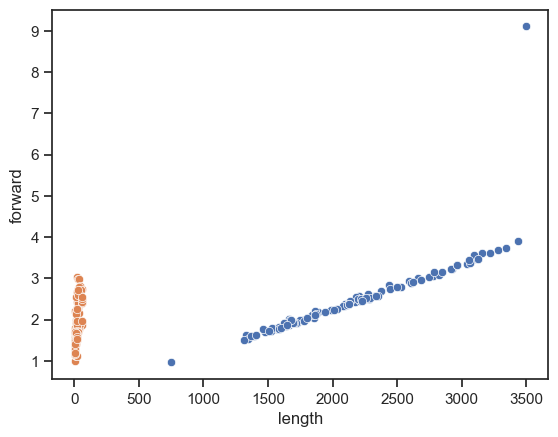

In [80]:
sns.scatterplot(
    data=ttt,
    x="length", y="forward"
)

sns.scatterplot(
    data=ttt_,
    x="length", y="gen10"
)

### segment description

In [103]:
avg_seq_widths = segments.groupby(['segment', 'seq']).length.agg(['mean', 'std', 'min', 'max']).reset_index().sort_values('seq')
avg_seq_widths = avg_seq_widths.rename(columns = {'mean': 'avg_length', 
                                                  'std': 'std_length', 
                                                  'min': 'min_length',
                                                  'max': 'max_length'})
avg_seq_widths['avg_length_rel'] = avg_seq_widths['avg_length'] / avg_seq_widths['avg_length'].sum()
avg_seq_widths['avg_cumlen'] = avg_seq_widths['avg_length_rel'].cumsum() 
avg_seq_widths

,segment,seq,avg_length,std_length,min_length,max_length,avg_length_rel,avg_cumlen
4,preamble,0,33.000000,0.000000,33,33,0.015491,0.015491
2,instruction,1,96.000000,0.000000,96,96,0.045064,0.060554
1,input,2,811.043269,514.669709,135,2285,0.380713,0.441267
5,question,3,1104.682692,241.211100,274,2022,0.518551,0.959818
3,postilla,4,60.000000,0.000000,60,60,0.028165,0.987983
0,generated,5,25.600481,13.398344,4,64,0.012017,1.000000


<Axes: xlabel='length', ylabel='Count'>

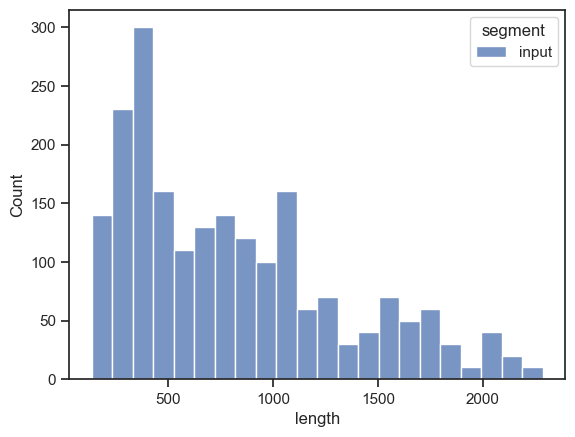

In [104]:
sns.histplot(segments[segments.segment=='input'], x='length', hue='segment', multiple='dodge', binwidth=100)

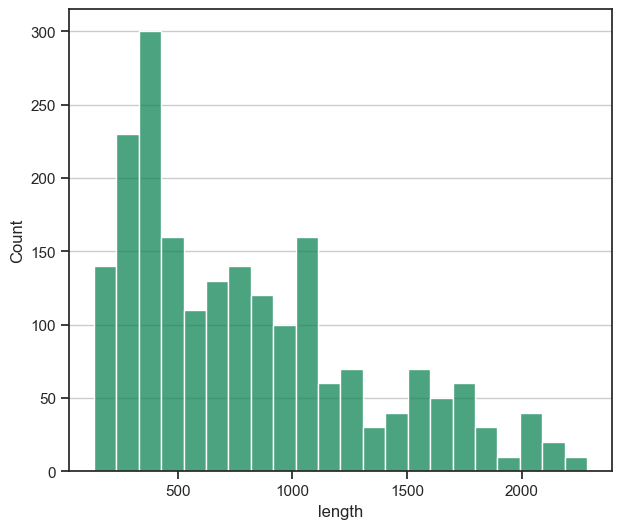

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 6))

sns.histplot(segments[segments.segment=='input'], x='length', color=Prism_10.mpl_colors[3], multiple='dodge', binwidth=100)

ax.yaxis.grid(True)

plt.show()

In [106]:
# Define background regions [(start, end, color, label)] based on the cumulative sections spans (for the first viz above)

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

myl = avg_seq_widths.avg_cumlen.to_list()
sections = ['preamble', 'instruction', 'input', 'question', 'postilla', 'generated']


first = (0., myl[0], palette[0], sections[0])
background_regions = [first]

for z1, z2, l, i in zip(myl, myl[1:], sections[1:], range(len(myl))):
    background_regions.append((z1,z2, palette[i+1], l))

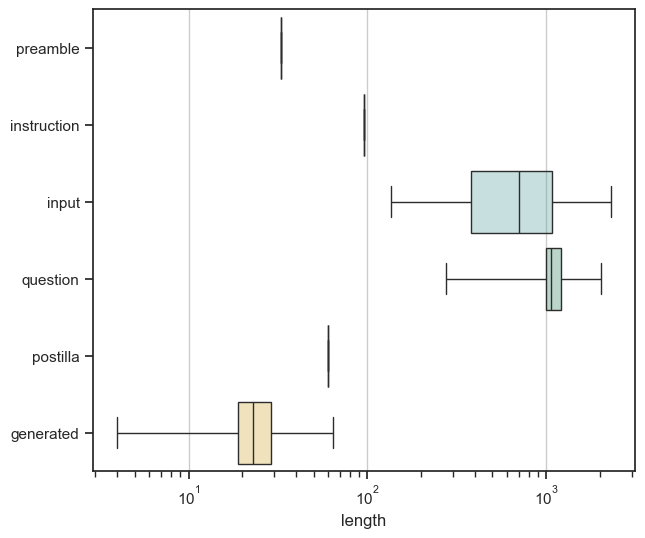

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

# Plot the orbital period with horizontal boxes
sns.boxplot(
    segments, x="length", y="segment", hue="segment",
    whis=[0, 100], palette=[b[2] for b in background_regions]
)

for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

ax.xaxis.grid(True)
ax.set(ylabel="")

plt.show()

In [108]:
# review truth

answers_m = answers.merge(truth[['run', 'pid', 'correct', 'loosely_correct']], on=['run','pid'])
answers_m['original_answer'] = answers_m.answer
answers_m.loc[~answers_m.regex_match.isnull(), 'answer'] = answers_m['regex_match']

truth_m = truth.copy()
truth_m.correct = truth_m.correct | truth_m.loosely_correct

In [109]:
myoutdict = {'truth': truth_m, 'segments': segments, 'answers': answers_m, 'model_name': model_name}

import pickle

with open(prefix + '/preprocessed.' + folder + '.pickle', 'wb') as handle:
    pickle.dump(myoutdict, handle, protocol=pickle.HIGHEST_PROTOCOL)
